In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# load dataset
df = pd.read_csv('fraud.csv')
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# count of fraud and non-fraud cases
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  6354407


In [4]:
# correct for oversampling of non-fraud cases
non_fraud_df = non_fraud_df.sample(n=len(fraud_df)*4)   # 4 times the number of fraud cases
df = pd.concat([fraud_df, non_fraud_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)   # shuffle
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,288,PAYMENT,1957.07,C436203935,13357.00,11399.93,M1735640252,0.00,0.00,0,0
1,578,CASH_OUT,68755.57,C1983934079,68755.57,0.00,C328707077,1555552.28,1624307.85,1,0
2,18,PAYMENT,1786.79,C525031764,51177.00,49390.21,M1357583648,0.00,0.00,0,0
3,186,CASH_OUT,212994.70,C25263140,1282.00,0.00,C36060360,1929313.78,2142308.48,0,0
4,6,CASH_OUT,17246.00,C1484518113,17246.00,0.00,C978609035,0.00,17246.00,1,0


In [5]:
print('Number of fraud cases: ', len(fraud_df))
print('Number of non-fraud cases: ', len(non_fraud_df))

Number of fraud cases:  8213
Number of non-fraud cases:  32852


In [6]:
# check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# use label encoding for type, nameOrig, nameDest
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,288,3,1957.07,29161,13357.00,11399.93,32944,0.00,0.00,0,0
1,578,1,68755.57,21033,68755.57,0.00,18644,1555552.28,1624307.85,1,0
2,18,3,1786.79,31067,51177.00,49390.21,30665,0.00,0.00,0,0
3,186,1,212994.70,25317,1282.00,0.00,19104,1929313.78,2142308.48,0,0
4,6,1,17246.00,10301,17246.00,0.00,28288,0.00,17246.00,1,0


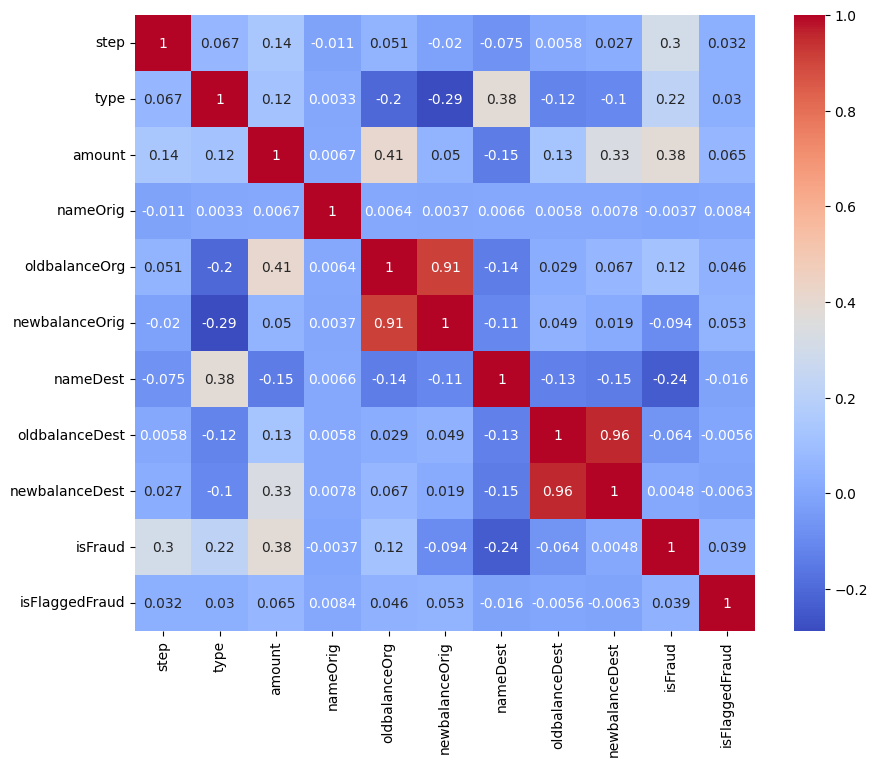

In [14]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [8]:
# split into train and test sets
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# scale the data for all but isFraud
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
lr_y_pred = log_reg.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, lr_y_pred))

Accuracy score:  0.9358334347984902


In [11]:
# train random forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)


RandomForestClassifier()

In [12]:
# evaluate model
rf_y_pred = random_forest.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print('Accuracy: ', accuracy_score(y_test, rf_y_pred))

[[6525   39]
 [  29 1620]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6564
           1       0.98      0.98      0.98      1649

    accuracy                           0.99      8213
   macro avg       0.99      0.99      0.99      8213
weighted avg       0.99      0.99      0.99      8213

Accuracy:  0.9917204431998052


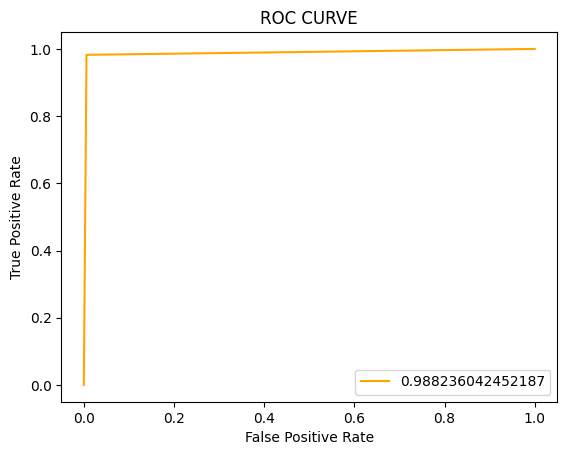

In [13]:
auc = roc_auc_score(y_test, rf_y_pred)
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
plt.plot(fpr, tpr, color = 'orange', label = auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()